<h1 align="center"> Auto insurance -  Predicting the premium of material claims - Modelling </h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, r2_score, mean_squared_error, mean_absolute_error
import scipy.stats
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.svm import SVR
from xgboost import XGBRegressor
from category_encoders import CountEncoder, TargetEncoder
import shap
from sklearn.neural_network import MLPRegressor

## Goal of the project : 
The objective of calculating an annual third-party premium (material + bodily) for the 36,311 contracts in the 2011 pricing dataset :
Indeed, we will determine the cost of third-party insurance for each contract on an annual basis. This premium is intended to cover material and bodily damages caused to third parties in the event of an accident where the insured party is at fault.


#### Step 1. Data cleaning

In [3]:
# Load the training dataset
training_data = pd.read_csv('training_clean.csv')

In [4]:
# Display the first rows of the training dataset to understand its structure
print("Training Dataset:")
training_data.head()

Training Dataset:


,PolNum,CalYear,Gender,Type,Category,Occupation,Age,Group1,Bonus,Poldur,Value,Adind,SubGroup2,Group2,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
0,200114978,2009,Male,C,Large,Employed,25,18,85,3,15080.0,0,L46,L,72.012883,365.0,1,0,0.0,0.0
1,200114994,2009,Male,E,Large,Employed,20,11,30,2,22370.0,1,O38,O,39.550411,365.0,1,0,0.0,0.0
2,200115001,2009,Female,E,Large,Unemployed,42,11,85,0,39650.0,0,Q28,Q,169.529148,365.0,2,0,0.0,0.0
3,200115011,2009,Female,C,Medium,Housewife,21,5,0,0,12600.0,1,L6,L,58.894688,365.0,1,0,0.0,0.0
4,200115015,2009,Female,D,Large,Employed,33,12,30,10,9065.0,0,N4,N,109.631885,365.0,2,0,0.0,0.0


The training dataset contains:

100,000 unique insurance contracts for the years 2009 and 2010e:
Here is a description of each column in the dataset.

| Column     | Description                                                                  |
|------------|------------------------------------------------------------------------------|
| PolNum     | Contract number                                                              |
| CalYear    | Subscription year                                                            |
| Gender     | Gender of the vehicle driver                                                 |
| Type       | Type of car                                                                  |
| Category   | Car category                                                                 |
| Occupation | Driver's occupation                                                          |
| Age        | Driver's age                                                                 |
| Group1     | Car group                                                                    |
| Bonus      | Bonus-Malus (a discount or surcharge applied based on the claims history)   |
| Poldur     | Age of the insurance contract                                                |
| Value      | Value of the insured vehicle                                                 |
| Adind      | Indicator for material coverage                                              |
| SubGroup2  | Driver's home sub-region                                                     |
| Group2     | Driver's home region                                                         |
| Density    | Population density                                                           |
| Expdays    | Exposure (in days)                                                           |
| Numtppd    | Number of third-party material claims                                        |
| Numtpbi    | Number of third-party bodily injury claims                                   |
| Indtppd    | Total cost of third-party material claims                                    |
| Indtpbi    | Total cost of third-party bodily injury claims                               |


In [5]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99979 entries, 0 to 99978
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PolNum      99979 non-null  int64  
 1   CalYear     99979 non-null  int64  
 2   Gender      99979 non-null  object 
 3   Type        99979 non-null  object 
 4   Category    99979 non-null  object 
 5   Occupation  99979 non-null  object 
 6   Age         99979 non-null  int64  
 7   Group1      99979 non-null  int64  
 8   Bonus       99979 non-null  int64  
 9   Poldur      99979 non-null  int64  
 10  Value       99979 non-null  float64
 11  Adind       99979 non-null  int64  
 12  SubGroup2   99979 non-null  object 
 13  Group2      99979 non-null  object 
 14  Density     99979 non-null  float64
 15  Exppdays    99979 non-null  float64
 16  Numtppd     99979 non-null  int64  
 17  Numtpbi     99979 non-null  int64  
 18  Indtppd     99979 non-null  float64
 19  Indtpbi     99979 non-nul

In [6]:
# Check for missing values in the training dataset
print("\nMissing Values in Training Dataset:")
print(training_data.isnull().sum())


Missing Values in Training Dataset:
PolNum        0
CalYear       0
Gender        0
Type          0
Category      0
Occupation    0
Age           0
Group1        0
Bonus         0
Poldur        0
Value         0
Adind         0
SubGroup2     0
Group2        0
Density       0
Exppdays      0
Numtppd       0
Numtpbi       0
Indtppd       0
Indtpbi       0
dtype: int64


In [7]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
count,9.997900e+04,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000,99979.000000
mean,2.002003e+08,2009.499935,41.124126,10.691725,-9.374319,5.470579,16358.767416,0.512178,117.142810,349.821137,0.147391,0.046780,106.110750,222.793486
std,6.217119e+04,0.500002,14.301168,4.687371,42.481030,4.591067,10253.792535,0.499854,79.493407,26.019809,0.436855,0.219528,444.979787,1859.763345
min,2.001149e+08,2009.000000,18.000000,1.000000,-50.000000,0.000000,1000.000000,0.000000,14.377142,302.500000,0.000000,0.000000,0.000000,0.000000
25%,2.001399e+08,2009.000000,30.000000,7.000000,-40.000000,1.000000,8380.000000,0.000000,50.566406,340.000000,0.000000,0.000000,0.000000,0.000000
50%,2.001649e+08,2009.000000,40.000000,11.000000,-30.000000,4.000000,14605.000000,1.000000,94.364623,365.000000,0.000000,0.000000,0.000000,0.000000
75%,2.002608e+08,2010.000000,51.000000,14.000000,10.000000,9.000000,22565.000000,1.000000,174.644525,365.000000,0.000000,0.000000,0.000000,0.000000
max,2.002858e+08,2010.000000,75.000000,20.000000,85.000000,15.000000,43842.500000,1.000000,297.385170,365.000000,7.000000,3.000000,12878.369910,69068.026292


In [8]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi
PolNum,1.000000,0.972664,0.002436,0.004251,-0.005043,-0.003839,-0.003455,0.001786,0.008234,-0.000613,0.016105,0.001248,0.016661,0.007752
CalYear,0.972664,1.000000,0.001772,0.003736,-0.004583,-0.002483,-0.003646,0.001794,0.008792,-0.001321,0.016163,-0.000018,0.017005,0.007686
Age,0.002436,0.001772,1.000000,0.090984,-0.240476,0.050505,0.018009,0.203077,0.003178,0.000702,-0.162977,-0.097232,-0.137944,-0.054483
Group1,0.004251,0.003736,0.090984,1.000000,-0.025149,0.004468,0.233053,0.020499,0.004397,0.003376,0.091433,0.026593,0.059905,0.002923
Bonus,-0.005043,-0.004583,-0.240476,-0.025149,1.000000,-0.009795,-0.004522,-0.048566,-0.004451,-0.000966,0.232109,0.072716,0.140836,0.038668
Poldur,-0.003839,-0.002483,0.050505,0.004468,-0.009795,1.000000,0.002160,0.012514,-0.001126,0.000556,-0.043410,-0.007581,-0.031188,-0.004157
Value,-0.003455,-0.003646,0.018009,0.233053,-0.004522,0.002160,1.000000,0.008062,0.001496,-0.000369,0.023835,0.007678,0.015609,0.001757
Adind,0.001786,0.001794,0.203077,0.020499,-0.048566,0.012514,0.008062,1.000000,0.003238,0.001833,-0.052193,-0.039510,-0.059232,-0.020369
Density,0.008234,0.008792,0.003178,0.004397,-0.004451,-0.001126,0.001496,0.003238,1.000000,-0.002740,0.120872,0.026306,0.105411,0.021309
Exppdays,-0.000613,-0.001321,0.000702,0.003376,-0.000966,0.000556,-0.000369,0.001833,-0.002740,1.000000,0.066077,0.043648,0.047665,0.024760


In [9]:
print("Valeurs uniques de la colonne Numtppd:", training_data['Numtppd'].unique())
print("Valeurs uniques de la colonne Numtpbi:", training_data['Numtpbi'].unique())
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus'].unique())

Valeurs uniques de la colonne Numtppd: [1 2 0 3 4 5 6 7]
Valeurs uniques de la colonne Numtpbi: [0 1 2 3]
Valeurs uniques de la colonne Indtppd: [   0.          740.30229036  207.32365675 ...  546.40798246  822.92046036
 5800.0189068 ]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 85  30   0  40  80 -20 -40 -30  20  50 -50 -10  10  70  60]


In [10]:
# Select only numeric columns
numeric_cols = training_data.select_dtypes(include=['number'])

# Calculate the 90th percentile for each numeric column
percentile_90 = numeric_cols.quantile(0.9)

# Count the number of values above the 90th percentile in each column
count_above_90 = (numeric_cols > percentile_90).sum()

# Calculate the percentage of values above the 90th percentile in each column
percentage_above_90 = (count_above_90 / len(numeric_cols)) * 100

# Display the percentages
print("Percentage of values above the 90th percentile in each column:")
print(percentage_above_90)

Percentage of values above the 90th percentile in each column:
PolNum      10.000100
CalYear      0.000000
Age          9.535002
Group1       7.822643
Bonus        8.957881
Poldur       7.146501
Value        9.993099
Adind        0.000000
Density      9.696036
Exppdays     0.000000
Numtppd      1.917403
Numtpbi      4.503946
Indtppd     10.000100
Indtpbi      4.503946
dtype: float64


In [12]:
#  Creating new target variable
training_data['Prime_ppd'] = training_data['Numtppd'] * training_data['Indtppd']

In [13]:
# Select only the numeric columns for correlation calculation
numeric_data = training_data.select_dtypes(include='number')

# Calculate the correlation between numeric columns
corr = numeric_data.corr()

# Display the correlation matrix
corr

,PolNum,CalYear,Age,Group1,Bonus,Poldur,Value,Adind,Density,Exppdays,Numtppd,Numtpbi,Indtppd,Indtpbi,Prime_ppd
PolNum,1.000000,0.972664,0.002436,0.004251,-0.005043,-0.003839,-0.003455,0.001786,0.008234,-0.000613,0.016105,0.001248,0.016661,0.007752,0.013383
CalYear,0.972664,1.000000,0.001772,0.003736,-0.004583,-0.002483,-0.003646,0.001794,0.008792,-0.001321,0.016163,-0.000018,0.017005,0.007686,0.014284
Age,0.002436,0.001772,1.000000,0.090984,-0.240476,0.050505,0.018009,0.203077,0.003178,0.000702,-0.162977,-0.097232,-0.137944,-0.054483,-0.106877
Group1,0.004251,0.003736,0.090984,1.000000,-0.025149,0.004468,0.233053,0.020499,0.004397,0.003376,0.091433,0.026593,0.059905,0.002923,0.053087
Bonus,-0.005043,-0.004583,-0.240476,-0.025149,1.000000,-0.009795,-0.004522,-0.048566,-0.004451,-0.000966,0.232109,0.072716,0.140836,0.038668,0.119747
Poldur,-0.003839,-0.002483,0.050505,0.004468,-0.009795,1.000000,0.002160,0.012514,-0.001126,0.000556,-0.043410,-0.007581,-0.031188,-0.004157,-0.027682
Value,-0.003455,-0.003646,0.018009,0.233053,-0.004522,0.002160,1.000000,0.008062,0.001496,-0.000369,0.023835,0.007678,0.015609,0.001757,0.015588
Adind,0.001786,0.001794,0.203077,0.020499,-0.048566,0.012514,0.008062,1.000000,0.003238,0.001833,-0.052193,-0.039510,-0.059232,-0.020369,-0.045816
Density,0.008234,0.008792,0.003178,0.004397,-0.004451,-0.001126,0.001496,0.003238,1.000000,-0.002740,0.120872,0.026306,0.105411,0.021309,0.091491
Exppdays,-0.000613,-0.001321,0.000702,0.003376,-0.000966,0.000556,-0.000369,0.001833,-0.002740,1.000000,0.066077,0.043648,0.047665,0.024760,0.038237


In [14]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Prime_ppd'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Prime_ppd: p-value = 0.9999854740534555
Cramer's V for Gender and Prime_ppd: 0.3406626443450569
Chi-squared test result for Type and Prime_ppd: p-value = 1.8750321378233167e-22
Cramer's V for Type and Prime_ppd: 0.8043150408995366
Chi-squared test result for Category and Prime_ppd: p-value = 0.009223793692081357
Cramer's V for Category and Prime_ppd: 0.5002183398907641
Chi-squared test result for Occupation and Prime_ppd: p-value = 1.0
Cramer's V for Occupation and Prime_ppd: 0.6804423712456945
Chi-squared test result for Group2 and Prime_ppd: p-value = 1.0
Cramer's V for Group2 and Prime_ppd: 1.0184739098742412


The p-value resulting from the Chi-squared test indicates the statistical significance of the relationship between the target variable and each categorical variable.
And the Cramer's V is as well a statistical measure used to assess the association between categorical variables. Cramer's V ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. It  provides a standardized measure of the strength of association, allowing for easier interpretation and comparison across different studies or datasets.
NB : Group 2 have a strong relationship and at the same time have a high p value which means that the variables can be independent ! 

#### Step 2. Feature engineering (Data pre-processing)

#### Predicting the Primeppd : 

In [43]:
# List of column names to select
columns_to_select = ['Gender', 'Type', 'Category', 'Occupation', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus', 'Exppdays', 'Poldur','Value','Group2']


# Select the columns and assign them to X
X = training_data[columns_to_select] # features
y = training_data["Prime_ppd"] # target variable

In [44]:
# Identification of missing values
X.isnull().sum()

Gender        0
Type          0
Category      0
Occupation    0
PolNum        0
CalYear       0
Age           0
Adind         0
Density       0
Bonus         0
Exppdays      0
Poldur        0
Value         0
Group2        0
dtype: int64

In [45]:
# Applying a pipeline on categorical and numerical feature
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(exclude=['object', 'bool']).columns

In [46]:
# Handling missing data and normalization of numeric data with MAX Abs Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", StandardScaler())])  # Normalization of numeric data after imputing for the missing values

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data


In [47]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [48]:
# As our target variable can be imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [49]:
preprocessor.fit(X_train, y_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

#### Step 3. Modelling

#### 1. Linear Regression

Intercept (reg_lin_model): 185.85198957923637
Coefficients (reg_lin_model): [-12.28058228  24.70670365 -89.40651413 -22.84929933 133.31743739
  99.40217993  37.73451429 -23.3123677   14.77978805 -40.39322748
  40.39322748 -12.46065529  -2.38707776 -12.86191843   2.40004175
  22.60799276   2.70161697  10.32266736 -15.91919139   5.59652403
 -45.96482002  -9.64276488  33.91375872 -48.29802685  69.99185304
  -7.68634746   6.23201702  57.58764579  45.05872604  54.60105876
 -90.1499636  -95.53149768  35.90625495  31.17455413 -37.19244795]
MAE_reg_lin_model:
Train_reg_lin_model: 291.42861412787056
Test_reg_lin_model: 288.6977784973197
MSE_reg_lin_model:
Train_reg_lin_model: 926131.3475936573
Test_reg_lin_model: 1188732.571331669
RMSE_reg_lin_model:
Train_reg_lin_model: 962.3571829594547
Test_reg_lin_model: 1090.290131722593
R2_SCORE_reg_lin_model:
Train_reg_lin_model: 0.03784771834865919
Test_reg_lin_model: 0.03237388473954661
MAPE_reg_lin_model - Mean Absolute Percentage Error:
Train_reg_lin

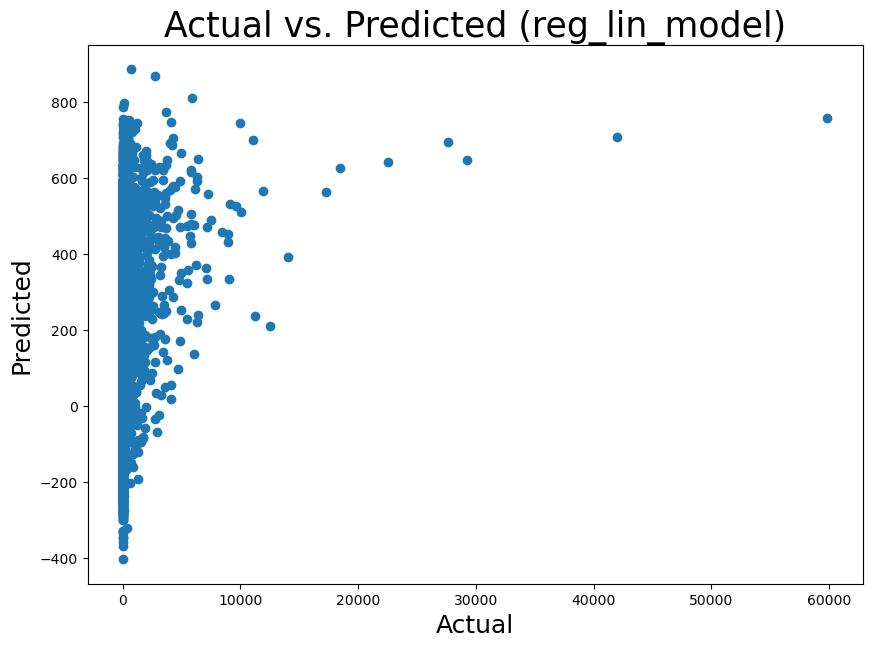

In [54]:
# Instantiate the Linear Regression model
reg_lin_model = LinearRegression()

# Fit the model on the training data
reg_lin_model.fit(X_train, y_train)

# Print intercept and coefficients
print("Intercept (reg_lin_model):", reg_lin_model.intercept_)
print("Coefficients (reg_lin_model):", reg_lin_model.coef_)

# Predicting on TRAIN & TEST DATA
train_predict_reg_lin = reg_lin_model.predict(X_train)
test_predict_reg_lin = reg_lin_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_reg_lin_model:")
print("Train_reg_lin_model:", mean_absolute_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_absolute_error(y_test, test_predict_reg_lin))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_reg_lin_model:")
print("Train_reg_lin_model:", mean_squared_error(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", mean_squared_error(y_test, test_predict_reg_lin))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_reg_lin_model:")
print("Train_reg_lin_model:", np.sqrt(mean_squared_error(y_train, train_predict_reg_lin)))
print("Test_reg_lin_model:", np.sqrt(mean_squared_error(y_test, test_predict_reg_lin)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_reg_lin_model:")
print("Train_reg_lin_model:", r2_score(y_train, train_predict_reg_lin))
print("Test_reg_lin_model:", r2_score(y_test, test_predict_reg_lin))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_reg_lin, train_predict_reg_lin = np.array(y_train), np.array(train_predict_reg_lin)
mape_train_reg_lin = np.mean(np.abs((train_y_reg_lin - train_predict_reg_lin) / train_y_reg_lin)) * 100
print("MAPE_reg_lin_model - Mean Absolute Percentage Error:")
print("Train_reg_lin_model:", mape_train_reg_lin)
print("Test_reg_lin_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_reg_lin)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (reg_lin_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_reg_lin)
plt.show()


#### 2. Polynomial Features

Polynomial Regression Metrics:
Mean Squared Error: 1150598.2690426125
R-squared Score: 0.06341513629774276
Intercept (poly_model): 22381129394574.574
Coefficients (poly_model): [ 3.19529291e+09 -1.56100899e+14 -1.95535768e+15  1.91646947e+15
 -3.27969168e+14  8.82346928e+13  7.93996993e+14  5.08626975e+14
  1.39762066e+15  1.11205444e+15  1.27989712e+15  1.59662264e+15
 -1.25272602e+15 -7.89435821e+14 -6.64398030e+14 -4.21371362e+14
  3.44596586e+14 -3.72699746e+14  2.15133777e+14 -6.70430445e+14
 -4.23786197e+14  1.15084422e+15 -2.56844542e+14 -9.00137004e+14
 -5.74062717e+14  1.81358479e+14 -8.42598306e+13  1.12709953e+15
  7.61760337e+13 -1.13410499e+14 -9.71622140e+13 -8.29524617e+14
 -3.13641461e+14  9.38382396e+14  3.66431702e+14 -1.95346994e+15
  7.57500000e+01 -1.50875000e+02 -1.87500000e+00 -1.65000000e+01
 -5.98437500e+01 -1.57500000e+01 -3.87500000e+00  2.53750000e+01
  2.18750000e+01 -9.09016063e+14 -9.09016063e+14 -2.85315541e+13
 -2.85315541e+13 -2.85315541e+13 -2.8531554

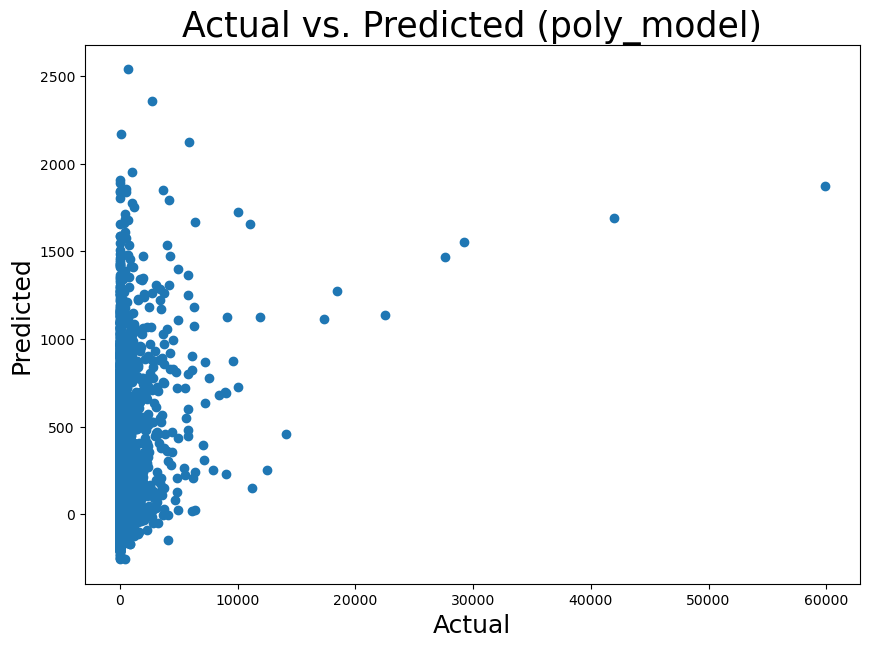

In [64]:
# Define the polynomial regression model
degree = 2  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train, y_train)

# Make predictions
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print("Polynomial Regression Metrics:")
print(f"Mean Squared Error: {mse_poly}")

r2_poly = r2_score(y_test, y_pred_poly)
print(f"R-squared Score: {r2_poly}")

# Calculate other metrics
print("Intercept (poly_model):", poly_model.named_steps['linearregression'].intercept_)
print("Coefficients (poly_model):", poly_model.named_steps['linearregression'].coef_)

# Predicting on TRAIN & TEST DATA
train_predict_poly = poly_model.predict(X_train)
test_predict_poly = poly_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_poly_model:")
print("Train_poly_model:", mean_absolute_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_absolute_error(y_test, test_predict_poly))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_poly_model:")
print("Train_poly_model:", mean_squared_error(y_train, train_predict_poly))
print("Test_poly_model:", mean_squared_error(y_test, test_predict_poly))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_poly_model:")
print("Train_poly_model:", np.sqrt(mean_squared_error(y_train, train_predict_poly)))
print("Test_poly_model:", np.sqrt(mean_squared_error(y_test, test_predict_poly)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_poly_model:")
print("Train_poly_model:", r2_score(y_train, train_predict_poly))
print("Test_poly_model:", r2_score(y_test, test_predict_poly))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_poly, train_predict_poly = np.array(y_train), np.array(train_predict_poly)
mape_train_poly = np.mean(np.abs((train_y_poly - train_predict_poly) / train_y_poly)) * 100
print("MAPE_poly_model - Mean Absolute Percentage Error:")
print("Train_poly_model:", mape_train_poly)
print("Test_poly_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_poly)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (poly_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_poly)
plt.show()



#### 3. SVR

SVR Regression Metrics:
Mean Squared Error (svr_model): 1251293.6514735501
R-squared Score (svr_model): -0.018550718829085655
MAE_svr_model:
Train_svr_model: 156.33452375441692
Test_svr_model: 151.1379368158111
MSE_svr_model:
Train_svr_model: 986947.767918225
Test_svr_model: 1251293.6514735501
RMSE_svr_model:
Train_svr_model: 993.4524487453967
Test_svr_model: 1118.6123776686677
R2_SCORE_svr_model:
Train_svr_model: -0.025334094608203683
Test_svr_model: -0.018550718829085655
MAPE_svr_model - Mean Absolute Percentage Error:
Train_svr_model: inf
Test_svr_model: inf


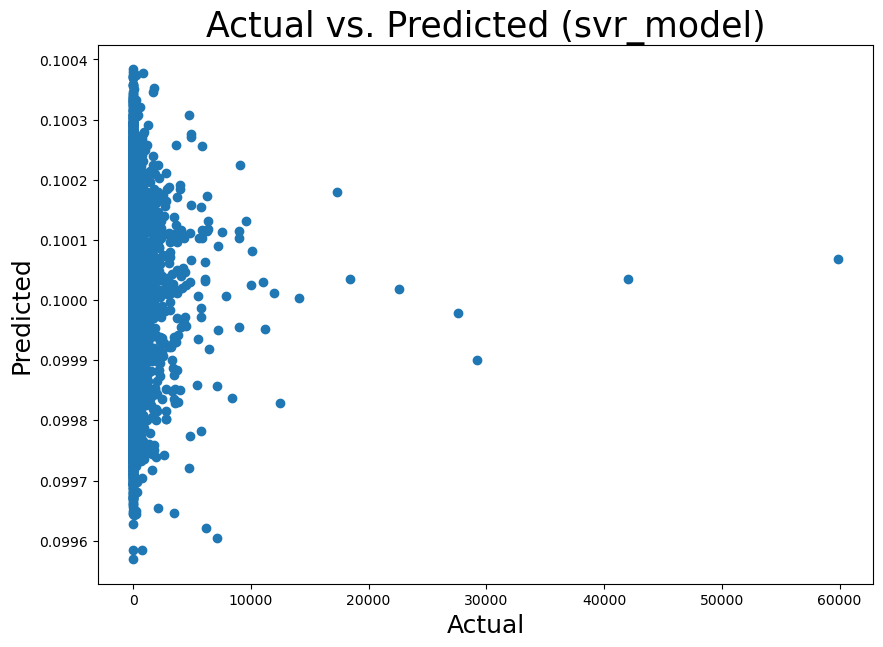

In [65]:
# Define the SVR model
svr_model = SVR(kernel='linear')

# Train the SVR model
svr_model.fit(X_train, y_train)

# Make predictions
y_pred_svr = svr_model.predict(X_test)

# Evaluate the model
mse_svr = mean_squared_error(y_test, y_pred_svr)
print("SVR Regression Metrics:")
print(f"Mean Squared Error (svr_model): {mse_svr}")

r2_svr = r2_score(y_test, y_pred_svr)
print(f"R-squared Score (svr_model): {r2_svr}")

# Predicting on TRAIN & TEST DATA
train_predict_svr = svr_model.predict(X_train)
test_predict_svr = svr_model.predict(X_test)

# Print MAE (Mean Absolute Error)
print("MAE_svr_model:")
print("Train_svr_model:", mean_absolute_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_absolute_error(y_test, test_predict_svr))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_svr_model:")
print("Train_svr_model:", mean_squared_error(y_train, train_predict_svr))
print("Test_svr_model:", mean_squared_error(y_test, test_predict_svr))
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_svr_model:")
print("Train_svr_model:", np.sqrt(mean_squared_error(y_train, train_predict_svr)))
print("Test_svr_model:", np.sqrt(mean_squared_error(y_test, test_predict_svr)))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_svr_model:")
print("Train_svr_model:", r2_score(y_train, train_predict_svr))
print("Test_svr_model:", r2_score(y_test, test_predict_svr))
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
train_y_svr, train_predict_svr = np.array(y_train), np.array(train_predict_svr)
mape_train_svr = np.mean(np.abs((train_y_svr - train_predict_svr) / train_y_svr)) * 100
print("MAPE_svr_model - Mean Absolute Percentage Error:")
print("Train_svr_model:", mape_train_svr)
print("Test_svr_model:", np.mean(np.abs((np.array(y_test) - np.array(test_predict_svr)) / np.array(y_test))) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (svr_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=test_predict_svr)
plt.show()

#### 4. RandomForest with Grid Search

Random Forest Regression Metrics (with GridSearchCV):
Mean Squared Error (rf_grid_model): 1143447.8555777383
R-squared Score (rf_grid_model): 0.06923555963801642
Best parameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
MAE_rf_grid_model:
Train_rf_grid_model: 225.93026084155966
Test_rf_grid_model: 250.89039965322675
MSE_rf_grid_model:
Train_rf_grid_model: 643773.1518011912
Test_rf_grid_model: 1143447.8555777383
RMSE_rf_grid_model:
Train_rf_grid_model: 802.3547543332633
Test_rf_grid_model: 1069.3212125351943
R2_SCORE_rf_grid_model:
Train_rf_grid_model: 0.3311879481449559
Test_rf_grid_model: 0.06923555963801642
MAPE_rf_grid_model - Mean Absolute Percentage Error:
Train_rf_grid_model: inf
Test_rf_grid_model: inf


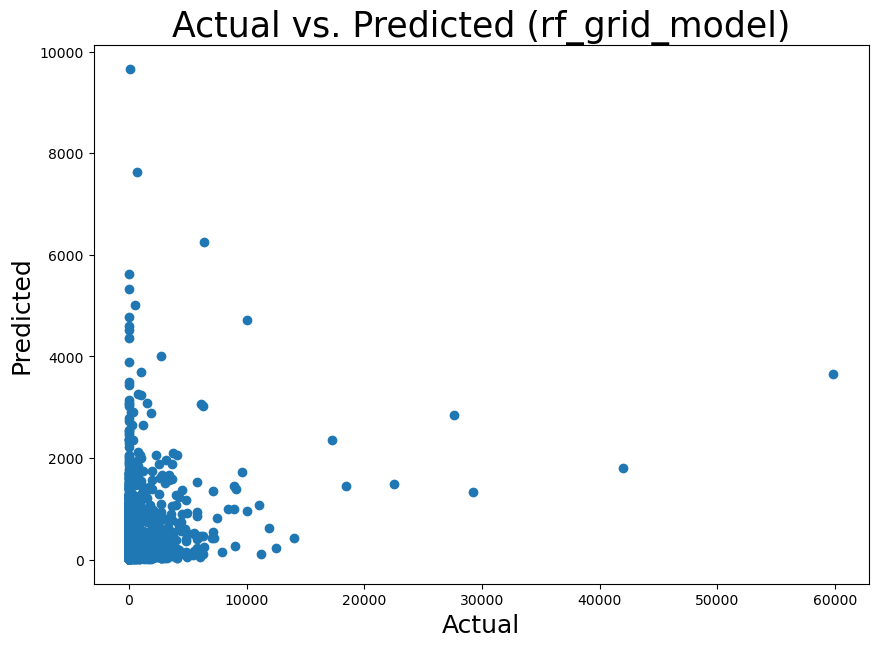

In [67]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Define the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Make predictions
y_pred_rf_grid_model = best_rf_model.predict(X_test)

# Evaluate the model
mse_rf_grid_model = mean_squared_error(y_test, y_pred_rf_grid_model)
print("Random Forest Regression Metrics (with GridSearchCV):")
print(f"Mean Squared Error (rf_grid_model): {mse_rf_grid_model}")

r2_rf_grid_model = r2_score(y_test, y_pred_rf_grid_model)
print(f"R-squared Score (rf_grid_model): {r2_rf_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_rf_grid_model:")
print("Train_rf_grid_model:", mean_absolute_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mean_absolute_error(y_test, y_pred_rf_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_rf_grid_model:")
print("Train_rf_grid_model:", mean_squared_error(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", mse_rf_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_rf_grid_model:")
print("Train_rf_grid_model:", np.sqrt(mean_squared_error(y_train, best_rf_model.predict(X_train))))
print("Test_rf_grid_model:", np.sqrt(mse_rf_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_rf_grid_model:")
print("Train_rf_grid_model:", r2_score(y_train, best_rf_model.predict(X_train)))
print("Test_rf_grid_model:", r2_rf_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_rf_grid_model = np.mean(np.abs((y_train - best_rf_model.predict(X_train)) / y_train)) * 100
print("MAPE_rf_grid_model - Mean Absolute Percentage Error:")
print("Train_rf_grid_model:", mape_train_rf_grid_model)
print("Test_rf_grid_model:", np.mean(np.abs((y_test - y_pred_rf_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (rf_grid_model)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_rf_grid_model)
plt.show()

#### 5. XGBoost with Grid Search

XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):
Mean Squared Error (best_xgb_model_grid): 1109309.740308723
R-squared Score (best_xgb_model_grid): 0.09702392235030066
Best parameters found by GridSearchCV:
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 800}
MAE_best_xgb_model_grid:
Train_best_xgb_model_grid: 239.9107799515193
Test_best_xgb_model_grid: 244.4361043178275
MSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 779456.0836504779
Test_best_xgb_model_grid: 1109309.740308723
RMSE_best_xgb_model_grid:
Train_best_xgb_model_grid: 882.8681009360786
Test_best_xgb_model_grid: 1053.237741589582
R2_SCORE_best_xgb_model_grid:
Train_best_xgb_model_grid: 0.19022776706574585
Test_best_xgb_model_grid: 0.09702392235030066
MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:
Train_best_xgb_model_grid: inf
Test_best_xgb_model_grid: inf


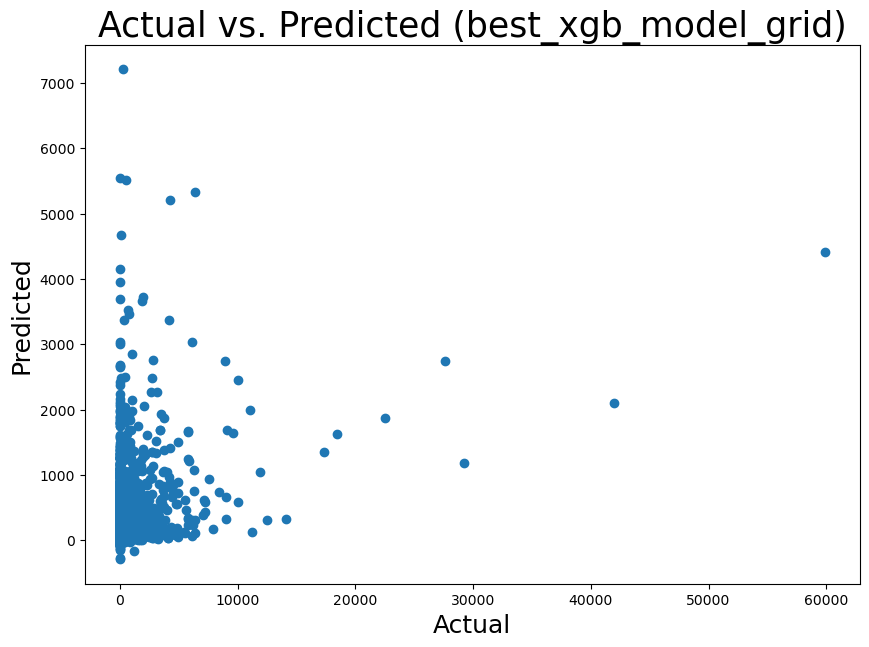

In [69]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators':  [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6], # Maximum depth of the tree
    'learning_rate': [0.01, 0.02, 0.03]  # Step size shrinkage used in update to prevents overfitting
}

# Define the XGBoost regression model
xgb_model = XGBRegressor(random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best model
best_xgb_model_grid = grid_search.best_estimator_

# Make predictions
y_pred_xgb_grid_model = best_xgb_model_grid.predict(X_test)

# Evaluate the model
mse_xgb_grid_model = mean_squared_error(y_test, y_pred_xgb_grid_model)
print("XGBoost Regression Metrics (with GridSearchCV) (best_xgb_model_grid):")
print(f"Mean Squared Error (best_xgb_model_grid): {mse_xgb_grid_model}")

r2_xgb_grid_model = r2_score(y_test, y_pred_xgb_grid_model)
print(f"R-squared Score (best_xgb_model_grid): {r2_xgb_grid_model}")

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Print MAE (Mean Absolute Error)
print("MAE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_absolute_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mean_absolute_error(y_test, y_pred_xgb_grid_model))
print("====================================")

# Print MSE (Mean Squared Error)
print("MSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", mean_squared_error(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", mse_xgb_grid_model)
print("====================================")

# Print RMSE (Root Mean Squared Error)
print("RMSE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", np.sqrt(mean_squared_error(y_train, best_xgb_model_grid.predict(X_train))))
print("Test_best_xgb_model_grid:", np.sqrt(mse_xgb_grid_model))
print("====================================")

# Print R2 SCORE
print("R2_SCORE_best_xgb_model_grid:")
print("Train_best_xgb_model_grid:", r2_score(y_train, best_xgb_model_grid.predict(X_train)))
print("Test_best_xgb_model_grid:", r2_xgb_grid_model)
print("====================================")

# Calculate and print MAPE (Mean Absolute Percentage Error)
mape_train_xgb_grid_model = np.mean(np.abs((y_train - best_xgb_model_grid.predict(X_train)) / y_train)) * 100
print("MAPE_best_xgb_model_grid - Mean Absolute Percentage Error:")
print("Train_best_xgb_model_grid:", mape_train_xgb_grid_model)
print("Test_best_xgb_model_grid:", np.mean(np.abs((y_test - y_pred_xgb_grid_model) / y_test)) * 100)

# Plot actual vs predicted value
plt.figure(figsize=(10, 7))
plt.title("Actual vs. Predicted (best_xgb_model_grid)", fontsize=25)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.scatter(x=y_test, y=y_pred_xgb_grid_model)
plt.show()


#### Step 5. Interpretability

In [74]:

# List of model names
model_names = ['SVR', 'Linear Regression', 'Polynomial Regression', 'Random Forest With GridSearch', 'XGBoost With GridSearch']

# List of predicted values for each model
all_y_pred = [test_predict_reg_lin, test_predict_poly, test_predict_rf_model, y_pred_rf_grid_model, y_pred_xgb_grid_model]

# List of true values for comparison
y_true = y_test  # Assuming y_test contains the true values

# List of metrics for each model
all_metrics = {
    'Model': model_names,
    'MAE': [mean_absolute_error(y_true, y_pred) for y_pred in all_y_pred],
    'MSE': [mean_squared_error(y_true, y_pred) for y_pred in all_y_pred],
    'RMSE': [np.sqrt(mean_squared_error(y_true, y_pred)) for y_pred in all_y_pred],
    'R2': [r2_score(y_true, y_pred) for y_pred in all_y_pred]
}

# Debugging: Print shapes of all_y_pred
for i, y_pred in enumerate(all_y_pred):
    print(f'Shape of y_pred_{model_names[i]}: {y_pred.shape}')

# Creating DataFrames
df_predictions = pd.DataFrame({f'y_pred_{model}': y_pred.flatten() for model, y_pred in zip(model_names, all_y_pred)})
df_metrics = pd.DataFrame(all_metrics)

# Display the DataFrames
print("\nPredictions DataFrame:")
(df_predictions)

Shape of y_pred_SVR: (9998,)
Shape of y_pred_Linear Regression: (9998,)
Shape of y_pred_Polynomial Regression: (9998,)
Shape of y_pred_Random Forest With GridSearch: (9998,)
Shape of y_pred_XGBoost With GridSearch: (9998,)

Predictions DataFrame:


,y_pred_SVR,y_pred_Linear Regression,y_pred_Polynomial Regression,y_pred_Random Forest With GridSearch,y_pred_XGBoost With GridSearch
0,499.204359,948.324219,1324.272473,720.241407,675.910645
1,5.041739,-87.675781,7.950431,65.008575,20.743319
2,79.263039,33.574219,12.869219,25.435942,32.250957
3,23.705016,-74.175781,18.214039,27.708710,43.393646
4,367.279504,345.074219,232.267582,193.482547,328.871094
...,...,...,...,...,...
9993,427.195532,539.949219,1078.626046,704.414485,588.838501
9994,162.479010,-10.800781,69.445355,64.777738,47.851543
9995,-151.240558,185.074219,63.635905,31.532168,31.496025
9996,392.666053,457.199219,586.785193,420.581834,324.770111


In [75]:
print("\nMetrics DataFrame:")
(df_metrics)


Metrics DataFrame:


,Model,MAE,MSE,RMSE,R2
0,SVR,288.697778,1.188733e+06,1090.290132,0.032374
1,Linear Regression,273.765759,1.150598e+06,1072.659438,0.063415
2,Polynomial Regression,287.442796,1.228928e+06,1108.570224,-0.000345
3,Random Forest With GridSearch,250.890400,1.143448e+06,1069.321213,0.069236
4,XGBoost With GridSearch,244.436104,1.109310e+06,1053.237742,0.097024


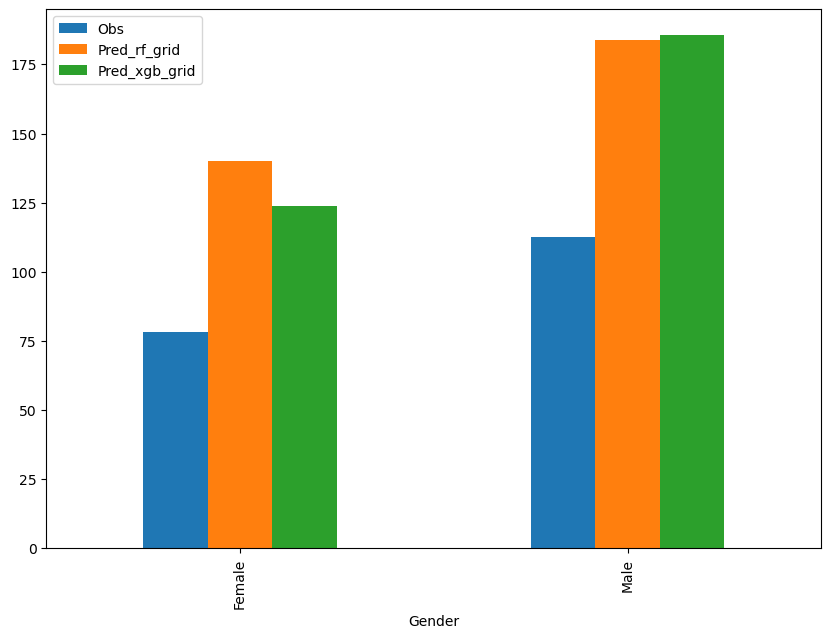

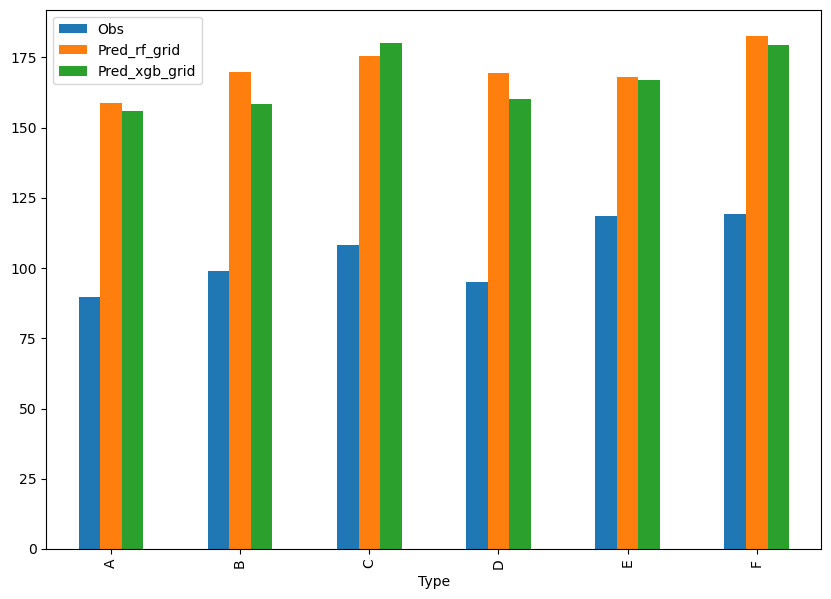

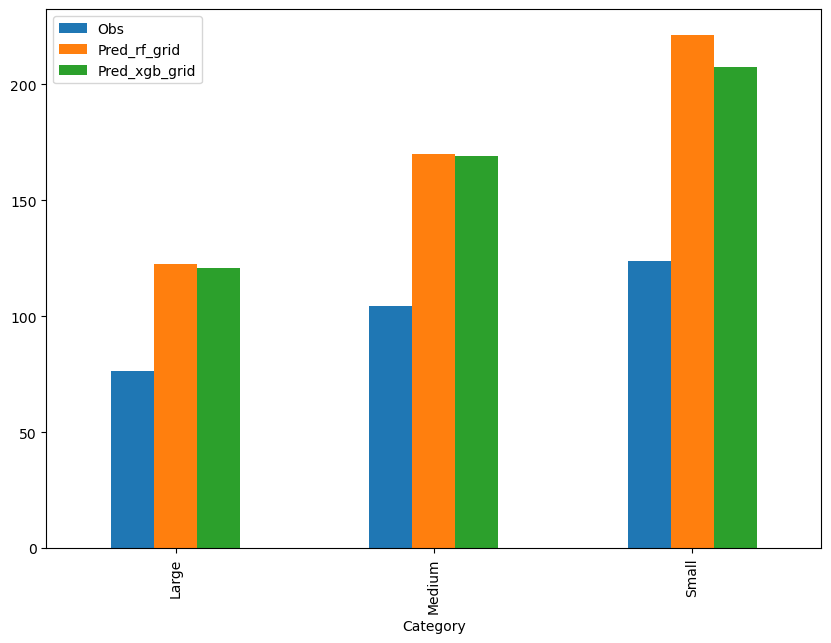

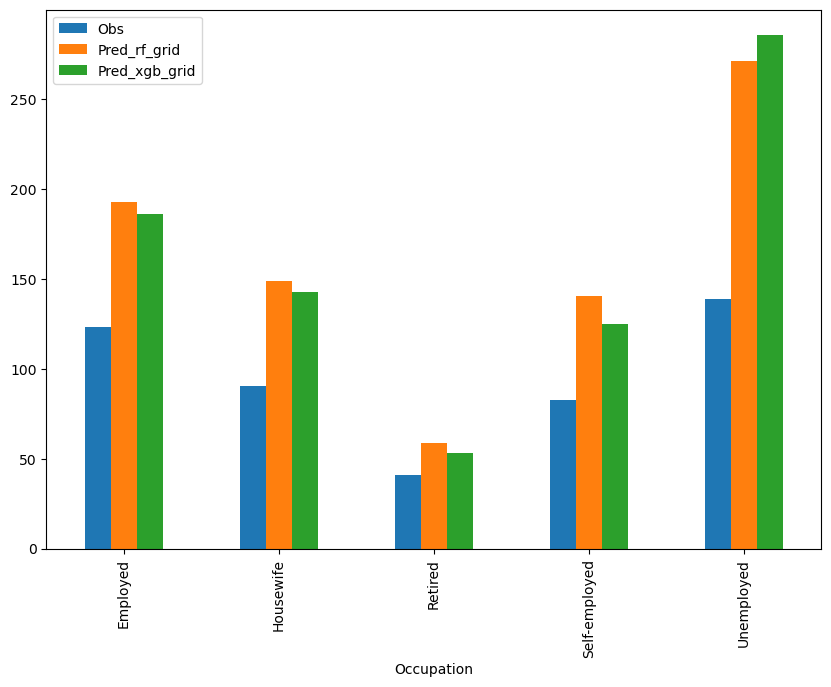

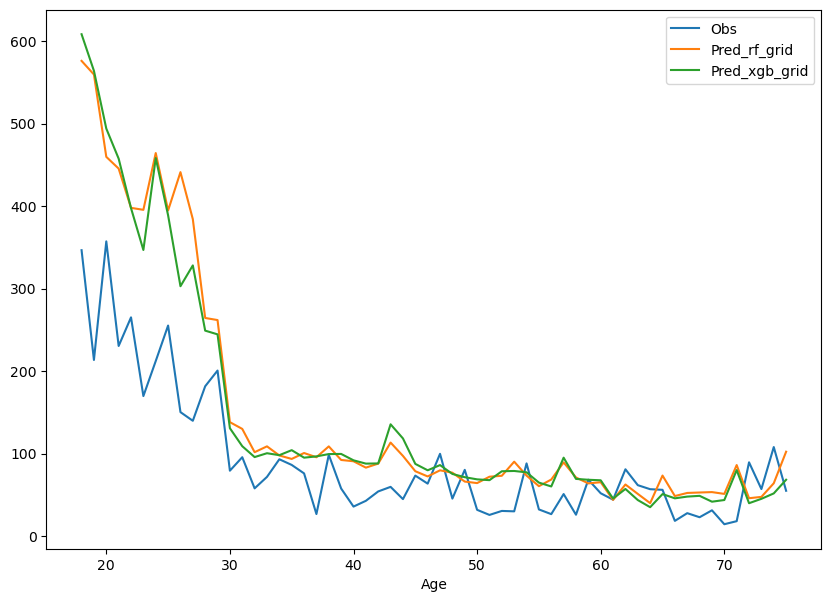

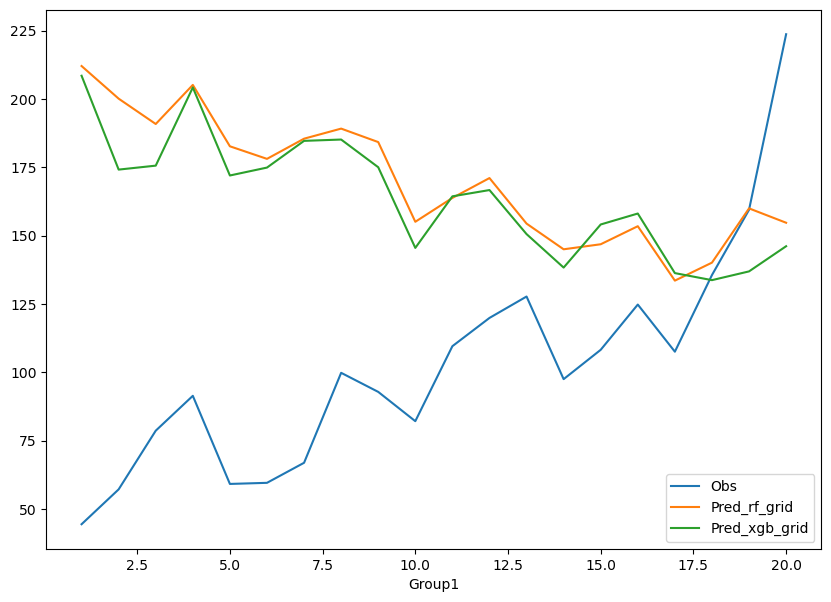

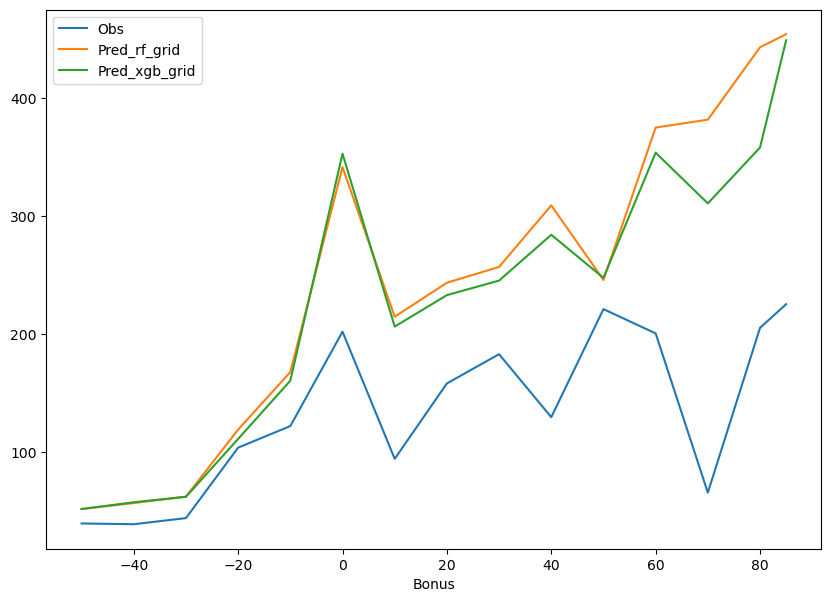

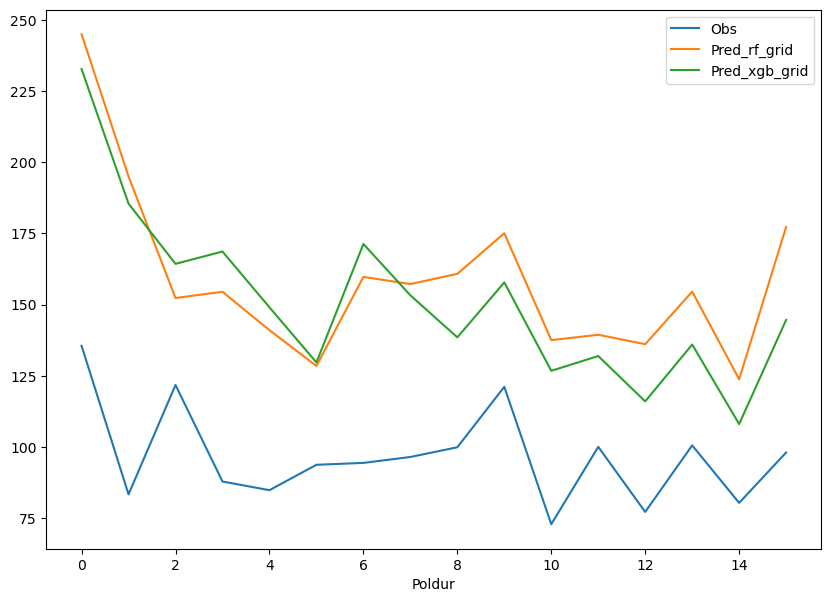

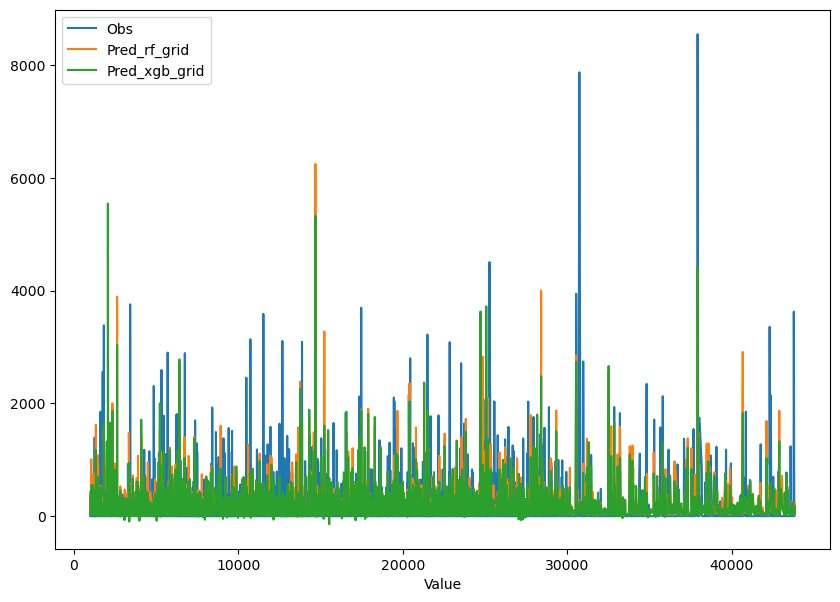

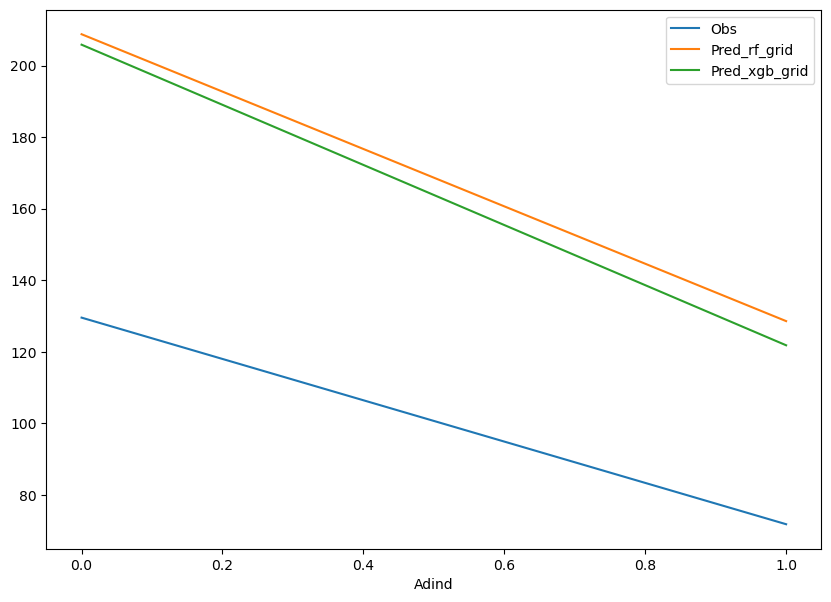

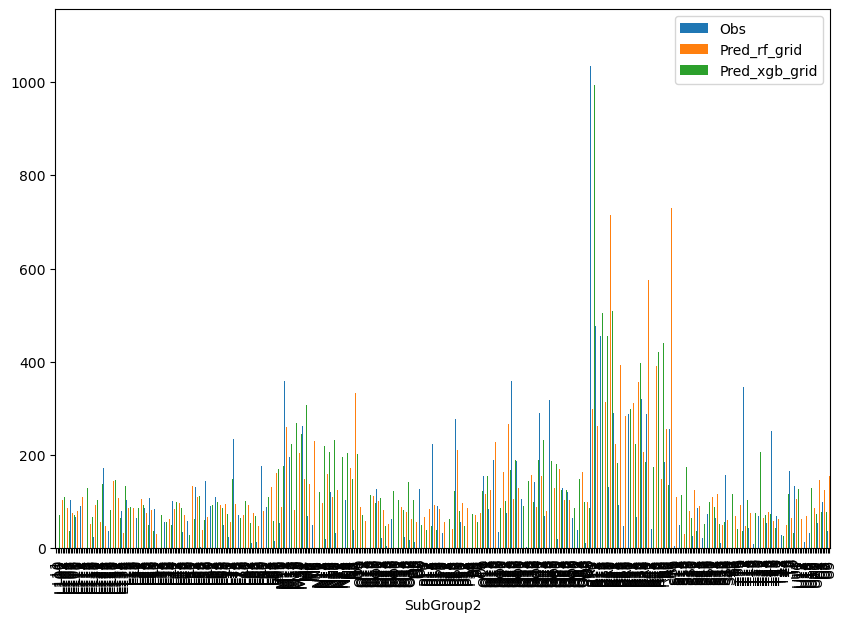

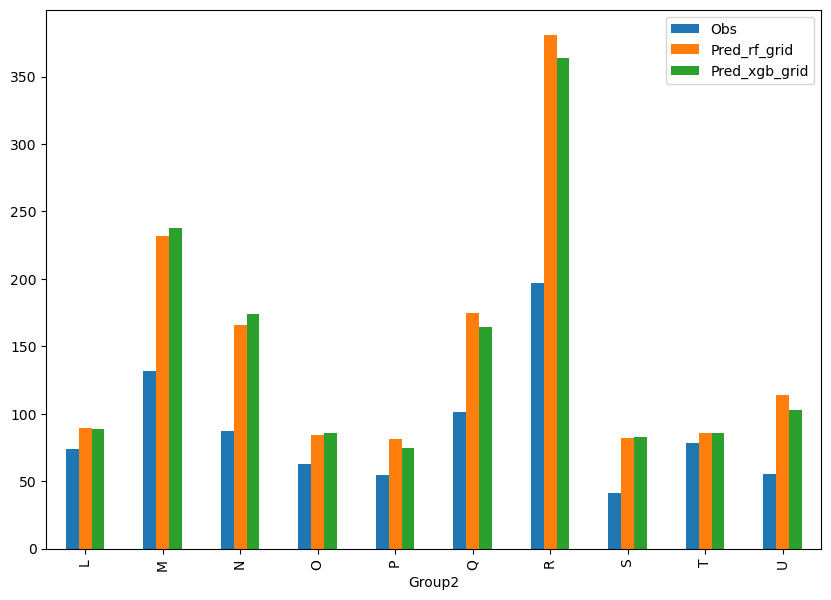

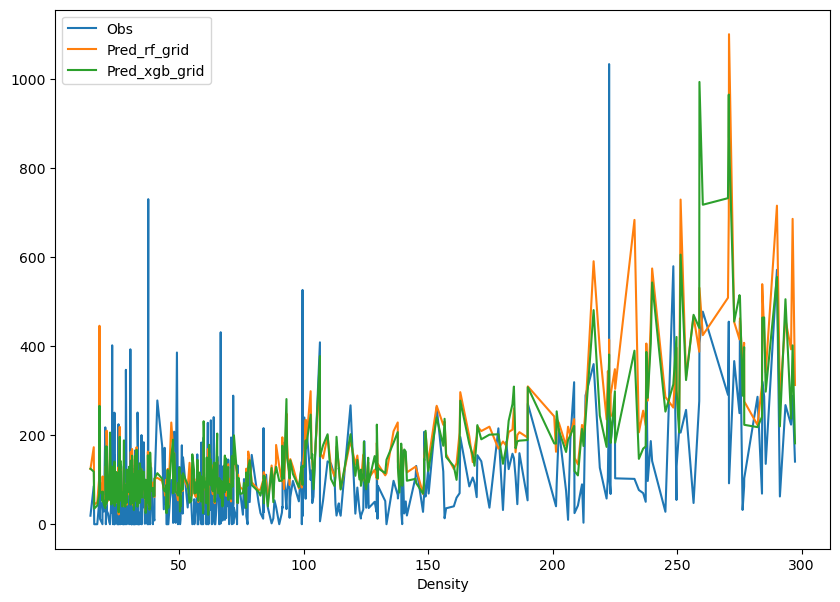

In [76]:
#Impact of target variable on the remaining variables
dataProv = pd.DataFrame(y_test_Ind.index)
dataProv.columns = ['index']
dataProv['Obs'] = np.array(y_test_Ind)
dataProv['Pred_rf_grid'] = y_pred_rf_grid_model
dataProv['Pred_xgb_grid'] = y_pred_xgb_grid_model
# dataProv['Pred_xgb_grid'] = p_xgb_grid
dataProv.head()

dataFinale = training_data.copy().reset_index().merge(dataProv)
dataFinale.head()
palette = "deep"

for var in dataFinale.columns[3:16]:
    dataPlot = dataFinale.groupby([var])[['Obs', 'Pred_rf_grid', 'Pred_xgb_grid']].mean()
    
    if dataFinale[var].dtypes == 'O':
        # Créer un graphique à barres avec des couleurs de la palette
        ax = dataPlot.plot(kind='bar', figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))
    else:
        # Créer un graphique linéaire avec des couleurs de la palette
        ax = dataPlot.plot(figsize=(10, 7))
        ax.set_prop_cycle(color=sns.color_palette(palette))

plt.show()